In [27]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib.patches import Polygon
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from matplotlib.colors import ListedColormap
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report

In [18]:
# read the dataset
df = pd.read_csv("data/cat_breeds_clean.csv")
df.head()

,Breed,Age_in_years,Age_in_months,Gender,Neutered_or_spayed,Body_length,Weight,Fur_colour_dominant,Fur_pattern,Eye_colour,Allowed_outdoor,Preferred_food,Owner_play_time_minutes,Sleep_time_hours,Country,Latitude,Longitude,Fur_colour_num,Fur_pattern_num
0,Angora,0.25,3.00,female,False,19.0,2.0,white,solid,blue,False,wet,46.0,16.0,France,43.296482,5.369780,0,0
1,Angora,0.33,4.00,male,False,19.0,2.5,white,solid,blue,False,wet,48.0,16.0,France,43.611660,3.877710,0,0
2,Angora,3.00,36.00,male,True,38.0,5.0,white,solid,amber,False,wet,16.0,14.0,France,43.296482,5.369780,0,0
3,Angora,1.17,14.04,female,True,25.0,3.0,white,solid,amber,False,wet,19.0,17.0,France,45.763420,4.834277,0,0
4,Angora,5.83,69.96,male,True,37.0,4.6,black,solid,green,True,dry,9.0,16.0,France,48.864716,2.349014,1,0


In [19]:
# form the design matrix
X = df[["Fur_colour_num", "Fur_pattern_num"]].values

# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# form the target data vector
y = df["Breed"].map({"Angora": 0, "Ragdoll": 1, "Maine Coon": 2}).values

In [20]:
# split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.3, random_state=42
)

In [21]:
# breeds to integers
breed_to_int = {breed: i for i, breed in enumerate(df["Breed"].unique())}
y = df["Breed"].map(breed_to_int).values.astype(int)
num_classes = len(breed_to_int)


In [22]:
# logistic regression model (specifically multiclass logisitic regression)
class MultiClassLogisticRegression:
    def __init__(self, X, num_classes, learning_rate=0.1, n_iters=1000, random_seed=1):
        """
        X: training data (num_samples x num_features)
        num_classes: number of classes (e.g., number of breeds)
        learning_rate: step size for weight updates
        n_iters: number of iterations
        """
        self.lr = learning_rate
        self.n_iters = n_iters
        self.random_seed = random_seed
        self.num_classes = num_classes
        self.initialize(X)
        
    def initialize(self, X):
        np.random.seed(self.random_seed)
        self.W = np.random.normal(0, 0.01, size=(X.shape[1], self.num_classes))
        
    def softmax(self, X):
        z = np.dot(X, self.W)
        exp_z = np.exp(z - np.max(z, axis=1, keepdims=True))
        return exp_z / np.sum(exp_z, axis=1, keepdims=True)
    
    def predict_probability(self, X):
        return self.softmax(X)
    
    def predict(self, X):
        prob = self.predict_probability(X)
        return np.argmax(prob, axis=1)
    
    def loss(self, probs, y_one_hot):
        return -np.sum(y_one_hot * np.log(probs + 1e-8)) / y_one_hot.shape[0]
    
    def fit(self, X, y):
        """
        y: integer labels 0,1,...,num_classes-1
        """
        y_one_hot = np.zeros((X.shape[0], self.num_classes))
        y_one_hot[np.arange(X.shape[0]), y] = 1
        
        self.losses = []
        
        for i in range(self.n_iters):
            probs = self.predict_probability(X)
            gradient = np.dot(X.T, (probs - y_one_hot)) / X.shape[0]
            self.W -= self.lr * gradient
            self.losses.append(self.loss(probs, y_one_hot))


In [31]:
# model training
model = MultiClassLogisticRegression(X_scaled, num_classes, learning_rate=0.1, n_iters=1000)
model.fit(X_scaled, y)
y_pred = model.predict(X_scaled)
accuracy = np.mean(y_pred == y)
loss_rate = 1 - accuracy
print("Accuracy:", accuracy)
print("Loss rate:", loss_rate)

print("\nClassification Report:")
breed_names = ["Angora", "Ragdoll", "Maine Coon"]
print(classification_report(y, y_pred, target_names=breed_names))

print("\nPredictions:", y_pred[:10])


Accuracy: 0.8663967611336032
Loss rate: 0.1336032388663968

Classification Report:
              precision    recall  f1-score   support

      Angora       0.70      0.83      0.76       178
     Ragdoll       0.86      0.80      0.83       234
  Maine Coon       0.98      0.93      0.96       329

    accuracy                           0.87       741
   macro avg       0.85      0.85      0.85       741
weighted avg       0.88      0.87      0.87       741


Predictions: [0 0 0 0 1 0 0 1 0 0]


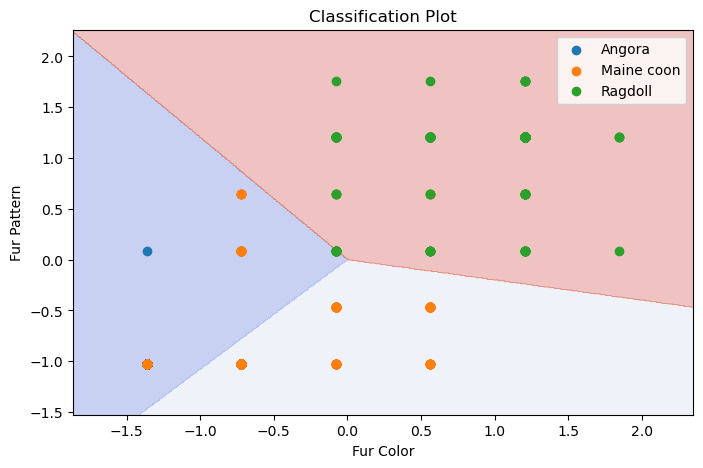

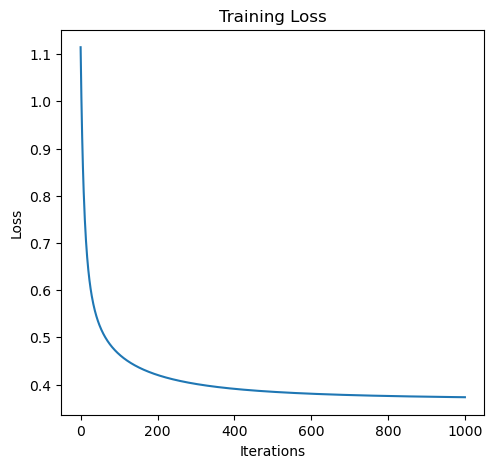

In [34]:
min_x, max_x = X_scaled[:,0].min() - 0.5, X_scaled[:,0].max() + 0.5
min_y, max_y = X_scaled[:,1].min() - 0.5, X_scaled[:,1].max() + 0.5
x1_span = np.linspace(min_x, max_x, 500)
x2_span = np.linspace(min_y, max_y, 500)
X1_span, X2_span = np.meshgrid(x1_span, x2_span)
X_grid = np.column_stack([X1_span.ravel(), X2_span.ravel()])

P_class = np.argmax(model.predict_probability(X_grid), axis=1).reshape(X1_span.shape)

plt.figure(figsize=(8,5))
plt.contourf(X1_span, X2_span, P_class, alpha=0.3, cmap='coolwarm')

for i, breed in enumerate(breed_to_int.keys()):
    plt.scatter(X_scaled[y==i, 0], X_scaled[y==i, 1], label=breed)

plt.xlabel("Fur Color")
plt.ylabel("Fur Pattern")
plt.title("Classification Plot")
plt.legend()
plt.show()

# loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1,2,2)
plt.plot(model.losses)
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Training Loss')
plt.show()


Confusion Matrix:
 [[148  30   0]
 [ 41 187   6]
 [ 22   0 307]]


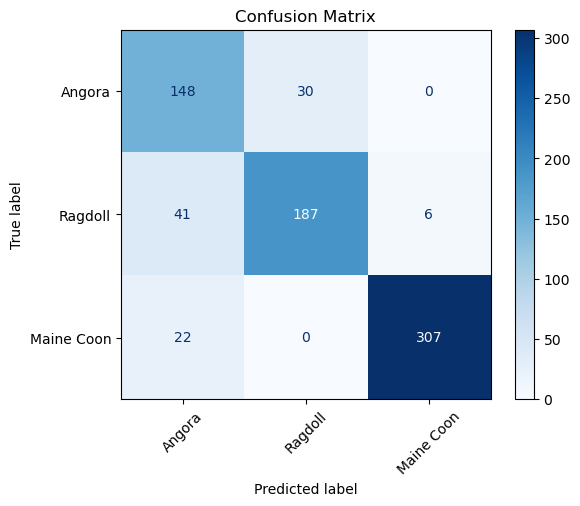

In [ ]:
# confusion matrix
cm = confusion_matrix(y, y_pred)
print("\nConfusion Matrix:\n", cm)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breed_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()